In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from functools import wraps
import numpy as np
import copy
import random
import torch

from torchvision import transforms, utils, datasets
from utils.utils import *
from utils.training import *
# from utils.training_batch import *
from utils.model import *
from utils.BYOL_models import *
from utils.similarity import *

In [3]:
# ('mnist', 'femnist', 'fmnist', 'cifar10', 'cifar100', 'svhn')
data_path = "./data"
dataset = "cifar10"
# ('noniid-labeldir', 'noniid-label#2', 'noniid-label#3','iid', 'default') default only for femnist
partition = "noniid-label#2"
client_num = 5
batch_size = 32
test_batch = 250
sim_weight = True

# Hyperparameters_List (H) = [rounds, number_of_clients, number_of_training_rounds_local, local_batch_size, lr_client, aggregation_frequence]

global_epochs = 1000
# global_epochs = 3
lr = 3e-4
dirichlet_beta = 0.4
norm = 'bn'
# every (avg_freq) epochs doing one aggregation
avg_freq = 10
# avg_freq = "exp"

# save_path = f"./model/SplitFSSLMaxpool_resnet18/resnet18Maxpooling_cifar10_{batch_size}_{partition}_{client_num}"
# save_path = f"./model/SplitFSSL_BYOL_Avg25times/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{partition}_{client_num}"
# save_path = f"./model/SplitFSSL_BYOL32_DifAvgtimes_0229/resnet18Maxpooling_{dataset}_{batch_size}_{avg_freq}_{partition}_{client_num}"
save_path = f"./model/SplitFSSL_BYOL32_similarity/resnet18Maxpooling_sim_weight({sim_weight})_{dataset}_{batch_size}_{avg_freq}_{partition}_{client_num}"
H = [global_epochs, client_num, batch_size, lr, avg_freq]

In [4]:
if dataset == "cifar100":
    nclasses = 100
else:
    nclasses = 10


# partition
net_dataidx_map, net_dataidx_map_test, traindata_cls_counts, testdata_cls_counts = partition_data(dataset, data_path, partition, client_num)
# get shared data idx form test data
shared_data_idx = shared_data(dataset, data_path, nclasses, 2500)
# get dataloader
train_loader_list = []
test_loader_list = []
for idx in range(client_num):
    
    dataidxs = net_dataidx_map[idx]
    # if net_dataidx_map_test is None:
    #     dataidx_test = None 
    # else:
    #     dataidxs_test = net_dataidx_map_test[idx]

    train_dl_local, shared_data_loader, train_ds_local, shared_data_ds_local = get_dataloader(dataset, 
                                                                   data_path, batch_size, test_batch, 
                                                                   dataidxs, shared_data_idx)
    train_loader_list.append(train_dl_local)
    # test_loader_list.append(test_dl_local)

Files already downloaded and verified
Files already downloaded and verified
partition: noniid-label#2
Data statistics Train: {0: {0: 5000, 1: 5000}, 1: {8: 5000, 9: 5000}, 2: {2: 5000, 3: 5000}, 3: {4: 5000, 5: 5000}, 4: {6: 5000, 7: 5000}}
Data statistics Test:
 {0: {0: 1000, 1: 1000}, 1: {8: 1000, 9: 1000}, 2: {2: 1000, 3: 1000}, 3: {4: 1000, 5: 1000}, 4: {6: 1000, 7: 1000}} 

Files already downloaded and verified
Files already downloaded and verified
Shared data has label: 0, 250 samples
Shared data has label: 1, 250 samples
Shared data has label: 2, 250 samples
Shared data has label: 3, 250 samples
Shared data has label: 4, 250 samples
Shared data has label: 5, 250 samples
Shared data has label: 6, 250 samples
Shared data has label: 7, 250 samples
Shared data has label: 8, 250 samples
Shared data has label: 9, 250 samples
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alre

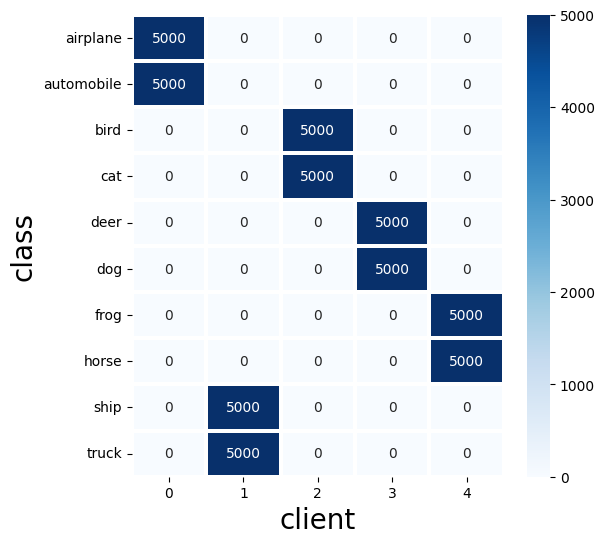

In [5]:
cls_count = np.zeros([10,client_num], dtype=int)
for k in range(client_num):
    for i in traindata_cls_counts[k]:
        cls_count[i][k] = traindata_cls_counts[k][i]

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(6,6))
sns.heatmap(cls_count, yticklabels=class_names, square=False,annot=True,fmt='d',linecolor='white',cmap='Blues',linewidths=1.5)
plt.xlabel('client',fontsize=20)
plt.ylabel('class',fontsize=20)
plt.show()

In [6]:
net = ResNet18()
client_model = BYOL_Client()
client_model_test = BYOL_Client()
server_model = BYOL_Server()
server_model.cuda()

client_weights = [1/5 for i in range(client_num)]
client_simweights = [[1 for i in range(client_num)] for i in range(client_num)]
client_models = [copy.deepcopy(client_model).cuda() for idx in range(client_num)]
client_tempmodels = [copy.deepcopy(client_model) for idx in range(client_num)]

# server_models = [copy.deepcopy(server_model).cuda() for idx in range(client_num)]

optimizer_server = torch.optim.Adam(server_model.parameters(), lr = H[3]) 
optimizer_clients = [torch.optim.Adam(client_models[i].parameters(), lr = H[3]) for i in range(len(client_models))]

In [13]:
client_model

BYOL_Client(
  (online_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [6]:
# epoch = 0 
checkpath = save_path + "/checkpoint.pth.tar" 
checkpoint = torch.load(checkpath)
epoch = checkpoint['glepoch']
print(epoch)
optimizer_server.load_state_dict(checkpoint['optimizer'][0])
if sim_weight:
    for clientidx in range(client_num):
        client_models[clientidx].online_encoder.load_state_dict(checkpoint['state_dict'][clientidx])
else:
    for localmodel in client_models:
        localmodel.online_encoder.load_state_dict(checkpoint['state_dict'])

for clientidx in range(client_num):
    optimizer_clients[clientidx].load_state_dict(checkpoint['optimizer'][clientidx+1])

1001


In [7]:
def training(client_models, server_model, optimizer_server, optimizer_clients, rounds, batch_size, avg_freq):
   
    # training loss
    train_loss = []
    test_loss = []
    test_accuracy = []
    best_accuracy = 0
    avg_times = 0
    # measure time
    start = time.time()
    pre_clients_features = None
    feature_sim_dict = {}
    
    
    writer = SummaryWriter(f'logs/SplitFSSL_BYOL32_similarity_feature0423/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{partition}_{client_num}')
    # writer = SummaryWriter(f'logs/SplitFSSL_BYOL_Avg25times/resnet18Maxpooling_cifar10_{batch_size}_{avg_freq}_{partition}_{client_num}')
    global_step = 0
    for curr_round in range(epoch, rounds+1):
        metrics = defaultdict(list)
        print(f"Global Round:", curr_round)
        w, local_loss = [], []
        
        num_batch = 0
        for i in train_loader_list:
            if num_batch < len(i):
                num_batch = len(i)
                
        train_iter = []
        for i in train_loader_list:
            train_iter.append(iter(i))
            
        batch_time = AverageMeter()
        data_time = AverageMeter()
        p_bar = tqdm(range(num_batch))

        # 聚合頻率參數成指數成長
        # alpha = expavg_times(curr_round)
        # 聚合頻率參數線性數成長
        # alpha = linear_growth(curr_round)
        # 聚合頻率參數成固定參數
        alpha = avg_freq
        
        for batch in range(num_batch):
            # print("0>", time.time() - start)
            optimizer_zero_grads(optimizer_server, optimizer_clients)
            
            online_proj_one_list = [None for _ in range(client_num)]
            online_proj_two_list = [None for _ in range(client_num)]
            target_proj_one_list = [None for _ in range(client_num)]
            target_proj_two_list = [None for _ in range(client_num)]

            # client forward
            # select 5 client to join training
            s_clients = []
            s_clients = range(client_num)
            # s_clients = random.sample(range(client_num), 6)
            # print("1>", time.time() - start)
            for i, client_id in enumerate(s_clients):
                # print("Client: ",i)
                # Compute a local update
                # print(i, "0>", time.time() - start)
                img1, img2, _ = next_data_batch(train_iter[client_id], train_loader_list[client_id])
                
                img1 = img1.cuda()
                img2 = img2.cuda()
                
                data_time.update(time.time() - start)
                # print(i, "1>", time.time() - start)
                # pass to client model
                # print("pass to client model")
                client_models[client_id].train()
                # print(i, "2>", time.time() - start)
                online_proj_one, online_proj_two, target_proj_one, target_proj_two = client_models[client_id](img1, img2)
                # print(i, "3>", time.time() - start)
                
                # store representations
                online_proj_one_list[i] = online_proj_one
                online_proj_two_list[i] = online_proj_two
                target_proj_one_list[i] = target_proj_one
                target_proj_two_list[i] = target_proj_two
                  

            
            # stack representations
            stack_online_proj_one = torch.cat(online_proj_one_list, dim = 0)
            stack_online_proj_two = torch.cat(online_proj_two_list, dim = 0)
            stack_target_proj_one = torch.cat(target_proj_one_list, dim = 0)
            stack_target_proj_two = torch.cat(target_proj_two_list, dim = 0)

            # print(">", time.time() - start)
            stack_online_proj_one, stack_online_proj_two, stack_target_proj_one, stack_target_proj_two = stack_online_proj_one.cuda(), stack_online_proj_two.cuda(), stack_target_proj_one.cuda(), stack_target_proj_two.cuda()
            
            # server computes
            # print("server computes")
            online_proj_one_grad, online_proj_two_grad, loss = train_server(stack_online_proj_one.detach(), stack_online_proj_two.detach(), stack_target_proj_one, stack_target_proj_two, server_model)
            local_loss.append((loss.item()))
            optimizer_server.step()
            # print(time.time() - start)
            # distribute gradients to clients
            # online_proj_one_grad, online_proj_two_grad = online_proj_one_grad.cpu(), online_proj_two_grad.cpu()
            gradient_dict_one = {key: [] for key in range(client_num)}
            gradient_dict_two = {key: [] for key in range(client_num)}
            
            for j in range(client_num):
                gradient_dict_one[j] = online_proj_one_grad[j*batch_size:(j+1)*batch_size, :]
                gradient_dict_two[j] = online_proj_two_grad[j*batch_size:(j+1)*batch_size, :]
                
            
            for i, client_id in enumerate(s_clients):
                online_proj_one_list[i].backward(gradient_dict_one[i])
                online_proj_two_list[i].backward(gradient_dict_two[i])
                optimizer_clients[client_id].step()
                client_models[client_id].update_moving_average()
            
            # if (batch+1)%10 == 0:
            #     print(f"Step [{batch}/{num_batch}]:\tLoss: {loss.item()}")
            
            del img1, img2
            writer.add_scalar("Loss/train_step", loss, global_step)
            metrics["Loss/train"].append(loss.item())
            global_step += 1
            
            batch_time.update(time.time() - start)
            start = time.time()
            #=======================================set p_bar description=======================================================
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. alpha: {ep_alpha}. Batch: {bt:.3f}s. Loss: {loss:.4f}.".format(
                    epoch=curr_round,
                    epochs=rounds,
                    batch=batch + 1,
                    iter=num_batch,
                    data=data_time.avg,
                    ep_alpha = alpha,
                    bt=batch_time.avg,
                    loss=loss.item()))
            p_bar.update()
            #=======================================set p_bar description=======================================================
            # in 32 batch size will have 250 batches, if aggregate per 10 batches will have 25 aggerations in one epoch
            # in 64 batch size will have 125 batches, if aggregate per 5 batches will have 25 aggerations in one epoch
            if batch == num_batch - 1 or ((batch+1) % alpha == 0):
                
                # calculate similarity matrix
                if avg_times % 10 == 0:
                    clients_similarity, mat_sim, clients_features = similarity_mat(save_path, curr_round, avg_times, s_clients, client_models, shared_data_loader, 
                                                            nclasses=512, nsamples=2500)
                    breakpoint()
                    
                    if pre_clients_features == None:
                        pre_clients_features = clients_features
                    else:
                        # 計算每個client與上次features的相似度
                        # breakpoint()
                        feature_sim_dict[curr_round] = cos_similarity(pre_clients_features, clients_features)
                        pre_clients_features = clients_features
                        print(f"epoch {curr_round} similarity : {feature_sim_dict[curr_round]}")
                    # 用softmax運算
                    # for i in range(client_num):
                    #     w = clients_similarity[i]
                    #     weight = torch.softmax(torch.tensor(w), dim=0)
                    #     client_simweights[i] = weight
                        
                    for i in range(client_num):
                        weights_sum = np.sum(clients_similarity[i])
                        for k, w in enumerate(clients_similarity[i]):
                            client_simweights[i][k] = w / weights_sum

                    # for idx, w in enumerate(client_simweights):
                    #     print(f"client {idx} weight : {w}, sum : {np.sum(w)}")
            
                # print("aggregate batch", batch)
                avg_times += 1
                with torch.no_grad():
                    # aggregate client models
                    # for key, param in model.named_parameters():
                    #     if param.requires_grad:
                    for key in client_model.state_dict().keys():
                        if "running" in key or "num_batches" in key:
                            continue
                        if sim_weight:
                            # 計算每個client的聚合權重
                            for client_idx in s_clients:
                                temp = torch.zeros_like(client_model.state_dict()[key]).to('cuda')
                                for i in s_clients:
                                    temp += client_simweights[client_idx][i] * client_models[i].state_dict()[key]                        
                                client_tempmodels[client_idx].state_dict()[key].data.copy_(temp)
                            for client_idx in range(len(client_models)):
                                client_models[client_idx].state_dict()[key].data.copy_(client_tempmodels[client_idx].state_dict()[key])
                            
                        
                        else:
                            temp = torch.zeros_like(client_model.state_dict()[key]).to('cuda')
                            for client_idx in s_clients:
                                temp += client_weights[client_idx] * client_models[client_idx].state_dict()[key]                        
                            client_model.state_dict()[key].data.copy_(temp)
                            for client_idx in range(len(client_models)):
                                # temp = 0.8 * client_model.state_dict()[key].to('cuda') + 0.2 * client_models[client_idx].state_dict()[key]
                                # client_models[client_idx].state_dict()[key].data.copy_(temp)
                                client_models[client_idx].state_dict()[key].data.copy_(client_model.state_dict()[key])
                            
    
        
        p_bar.close()
        # scheduler_server.step()
        for k, v in metrics.items():
            writer.add_scalar(k, np.array(v).mean(), curr_round)


        # loss
        loss_avg = sum(local_loss) / len(local_loss)
        train_loss.append(loss_avg)
        if curr_round % 5 == 0:
            optimizer_dict = []
            optimizer_dict.append(optimizer_server.state_dict())            
            for client_idx in range(client_num):
                optimizer_dict.append(optimizer_clients[client_idx].state_dict())
            if sim_weight:
                state_dict = []
                for cid in range(client_num):
                    state_dict.append(client_models[cid].online_encoder.cpu().state_dict())
                    client_models[cid].to('cuda')
            else:
                state_dict = client_model.online_encoder.cpu().state_dict()
            save_checkpoint({
                'glepoch': curr_round+1,
                'state_dict': state_dict,
                'optimizer': optimizer_dict,
                'feature_dict': feature_sim_dict,
            }, save_path)
        if curr_round % 100 == 0:
            if sim_weight:
                if not os.path.exists(save_path + f"/epoch_{curr_round}"):
                    os.makedirs(save_path + f"/epoch_{curr_round}")
                for cid in range(client_num):
                    torch.save(client_models[cid].online_encoder.cpu().state_dict(), save_path + f"/epoch_{curr_round}/client_{cid}.pt")
                    client_models[cid].to('cuda')      
            else:
                torch.save(client_model.online_encoder.cpu().state_dict(), save_path + f"_{curr_round}_epoch.pt")
        
        
        print(f"Global round: {curr_round} | Average loss: {loss_avg}")
        # print('best_accuracy:', best_accuracy, '---Round:', curr_round, '---lr', lr, '----localEpocs--', E)

    end = time.time()
   
    print("Training Done!")
    print("Total time taken to Train: {}".format(end - start))
    print(f"Total average times : {avg_times}")

    return client_models, client_model, train_loss

In [8]:
print(save_path)

./model/SplitFSSL_BYOL32_similarity/resnet18Maxpooling_sim_weight(True)_cifar10_32_10_noniid-label#2_5


In [9]:
client_models, client_model, train_loss = training(client_models, server_model, optimizer_server, optimizer_clients, H[0], H[2], H[4])

Training Done!
Total time taken to Train: 0.0007898807525634766
Total average times : 0


In [10]:
if sim_weight:
    if not os.path.exists(save_path + f"/final"):
        os.makedirs(save_path + f"/final")
    for cid in range(client_num):
        torch.save(client_models[cid].online_encoder.cpu().state_dict(), save_path + f"/final/client_{cid}.pt")
else:
    torch.save(client_model.online_encoder.cpu().state_dict(), save_path + "_final.pt")

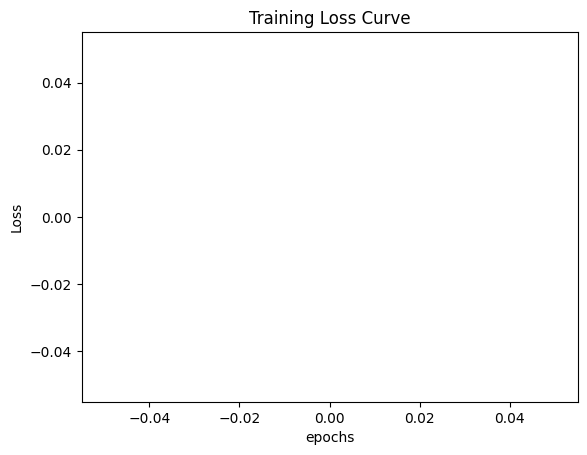

In [11]:
# plot training losses
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()